In [1]:
# Import necessary libraries
import cx_Oracle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import re
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

In [2]:
# --- Configuration for Oracle DB connection ---
hostname = 'localhost'
port = 1521
sid = 'localcr'
username = 'BANK_REVIEWS'
password = 'bankreviews'
dsn = cx_Oracle.makedsn(hostname, port, sid=sid)


In [3]:
# --- 1. Load Data from Oracle DB ---
try:
    connection = cx_Oracle.connect(user=username, password=password, dsn=dsn)
    query = """
    SELECT
        review_text,
        rating,
        review_date,
        bank_name,
        source,
        processed_review,
        sentiment_score,
        sentiment
    FROM
        reviews
    """
    df = pd.read_sql(query, connection)
    print("✅ Data loaded successfully from Oracle database.")
    print(f"Total records loaded: {len(df)}")
   
except cx_Oracle.Error as e:
    error_obj, = e.args
    print(f"Error connecting to Oracle or querying data: {error_obj.message}")
    print("Please ensure your database is running and connection details are correct (username, password, DSN).")
    
    exit() 
finally:
    if 'connection' in locals() and connection:
        connection.close()

✅ Data loaded successfully from Oracle database.
Total records loaded: 1030


In [4]:
# --- 2. Initial Data Preprocessing for Analysis ---

df['REVIEW_DATE'] = pd.to_datetime(df['REVIEW_DATE'], errors='coerce')
df['RATING'] = pd.to_numeric(df['RATING'], errors='coerce')
df['SENTIMENT_SCORE'] = pd.to_numeric(df['SENTIMENT_SCORE'], errors='coerce')

# Drop rows with critical NaNs
df.dropna(subset=['RATING', 'SENTIMENT_SCORE', 'REVIEW_DATE', 'PROCESSED_REVIEW', 'SENTIMENT'], inplace=True)

df['PROCESSED_REVIEW'] = df['PROCESSED_REVIEW'].astype(str).fillna('')
df['SENTIMENT'] = df['SENTIMENT'].astype(str).fillna('neutral').str.lower() 

print("\nData types after loading and initial processing for analysis:")
print(df.info())



Data types after loading and initial processing for analysis:
<class 'pandas.core.frame.DataFrame'>
Index: 1013 entries, 0 to 1029
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   REVIEW_TEXT       1013 non-null   object        
 1   RATING            1013 non-null   int64         
 2   REVIEW_DATE       1013 non-null   datetime64[ns]
 3   BANK_NAME         1013 non-null   object        
 4   SOURCE            1013 non-null   object        
 5   PROCESSED_REVIEW  1013 non-null   object        
 6   SENTIMENT_SCORE   1013 non-null   float64       
 7   SENTIMENT         1013 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 71.2+ KB
None


In [5]:
# --- 3. Insights Generation ---

positive_reviews = df[df['SENTIMENT'] == 'positive']['PROCESSED_REVIEW']
negative_reviews = df[df['SENTIMENT'] == 'negative']['PROCESSED_REVIEW']

# Function to extract top keywords using TF-IDF
def get_top_keywords(text_series, num_words=15, ngram_range=(1, 2)):
    """
    Extracts top keywords/ using TF-IDF.
    """
    if text_series.empty or text_series.str.strip().eq('').all():
        return {} 
    
    non_empty_text = text_series[text_series.str.strip() != '']
    if non_empty_text.empty:
        return {}

    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=ngram_range, max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(non_empty_text)
    feature_names = vectorizer.get_feature_names_out()
    
    # Sum TF-IDF scores for each word across all documents
    sums = tfidf_matrix.sum(axis=0)
    scores = [(feature_names[col], sums[0, col]) for col in range(len(feature_names))]
    scores.sort(key=lambda x: x[1], reverse=True)
    return {word: score for word, score in scores[:num_words]}

print("\n--- Identifying Drivers (Top Positive Keywords)")
drivers = get_top_keywords(positive_reviews, num_words=10, ngram_range=(1,2))
if drivers:
    for word, score in drivers.items():
        print(f"- {word} (Score: {score:.2f})")
else:
    print("No sufficient positive reviews or keywords identified.")

print("\n--- Identifying Pain Points (Top Negative Keywords)")
pain_points = get_top_keywords(negative_reviews, num_words=10, ngram_range=(1,2))
if pain_points:
    for word, score in pain_points.items():
        print(f"- {word} (Score: {score:.2f})")
else:
    print("No sufficient negative reviews or keywords identified.")



--- Identifying Drivers (Top Positive Keywords)
- good (Score: 66.77)
- app (Score: 51.49)
- good app (Score: 26.81)
- nice (Score: 26.07)
- easy (Score: 18.81)
- amazing (Score: 17.40)
- like (Score: 16.78)
- bank (Score: 16.12)
- great (Score: 16.01)
- use (Score: 15.60)

--- Identifying Pain Points (Top Negative Keywords)
- app (Score: 11.05)
- bad (Score: 11.01)
- bad app (Score: 5.97)
- work (Score: 4.38)
- bank (Score: 3.54)
- poor (Score: 3.38)
- good (Score: 3.01)
- banking (Score: 2.90)
- time (Score: 2.69)
- mobile (Score: 2.43)


In [6]:
# Compare Banks
print("\n--- Comparing Banks ---")
# Overall average rating per bank
avg_rating_per_bank = df.groupby('BANK_NAME')['RATING'].mean().sort_values(ascending=False)
print("\nAverage Rating per Bank:")
print(avg_rating_per_bank)



--- Comparing Banks ---

Average Rating per Bank:
BANK_NAME
Dashen    4.378453
CBE       4.063492
BOA       2.812500
Name: RATING, dtype: float64


In [7]:
# Sentiment distribution per bank
sentiment_counts_per_bank = df.groupby('BANK_NAME')['SENTIMENT'].value_counts(normalize=True).unstack(fill_value=0)
print("\nSentiment Distribution per Bank (%):")
print((sentiment_counts_per_bank * 100).round(2))



Sentiment Distribution per Bank (%):
SENTIMENT  negative  neutral  positive
BANK_NAME                             
BOA           24.70    36.31     38.99
CBE            7.62    30.16     62.22
Dashen         4.97    20.17     74.86


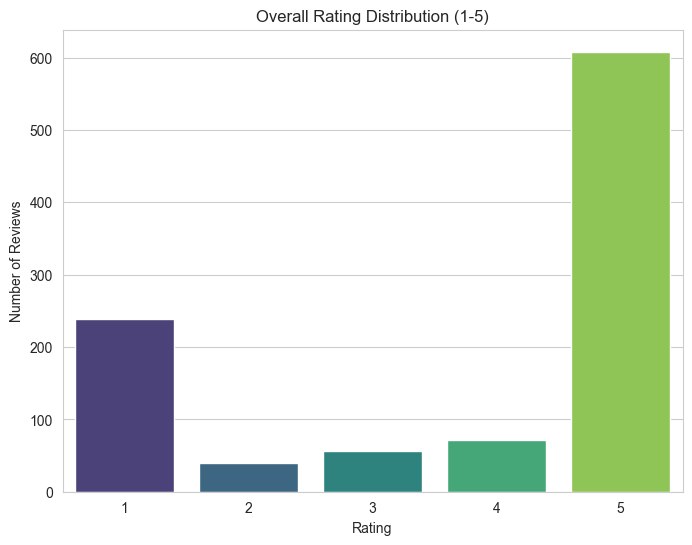

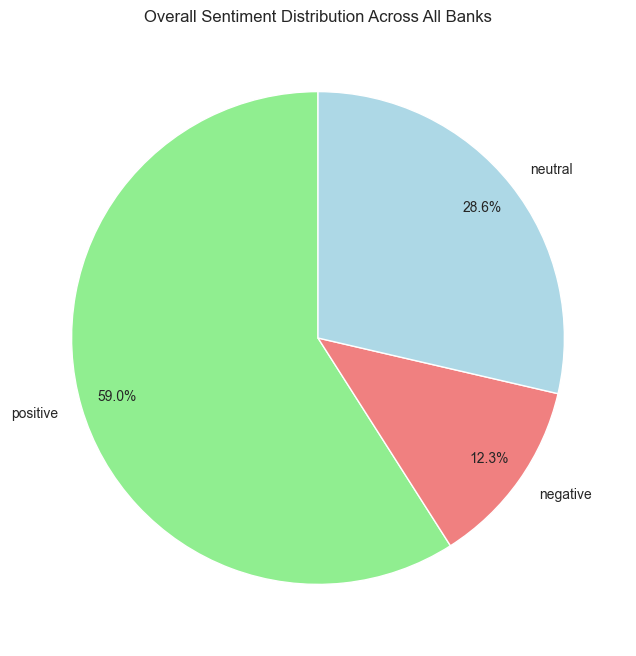

In [8]:
# --- 4. Visualization ---

# Plot 1: Overall Rating Distribution (Histogram/Countplot)
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='RATING', palette='viridis', order=sorted(df['RATING'].unique()))
plt.title('Overall Rating Distribution (1-5)')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

# Plot 2: Sentiment Distribution Across All Banks (Pie Chart)
plt.figure(figsize=(8, 8))
sentiment_counts = df['SENTIMENT'].value_counts(normalize=True) * 100
colors = {'positive': 'lightgreen', 'negative': 'lightcoral', 'neutral': 'lightblue'}
sentiment_counts = sentiment_counts.reindex(['positive', 'negative', 'neutral'], fill_value=0)
sentiment_colors = [colors[s] for s in sentiment_counts.index]

sentiment_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=sentiment_colors,
    pctdistance=0.85 
)
plt.title('Overall Sentiment Distribution Across All Banks')
plt.ylabel('')
plt.show()


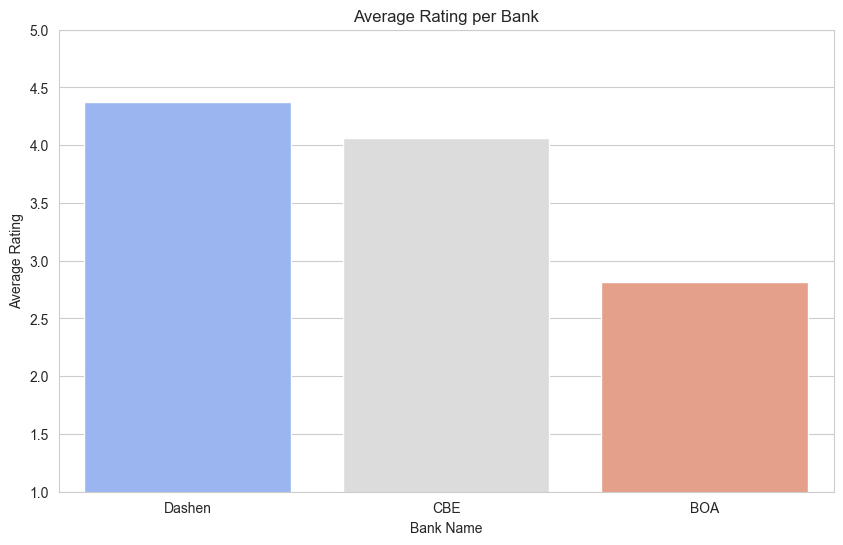

In [9]:
# Plot 3: Average Rating per Bank (Bar Plot)
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_rating_per_bank.index, y=avg_rating_per_bank.values, palette='coolwarm')
plt.title('Average Rating per Bank')
plt.xlabel('Bank Name')
plt.ylabel('Average Rating')
plt.ylim(1, 5) 
plt.show()


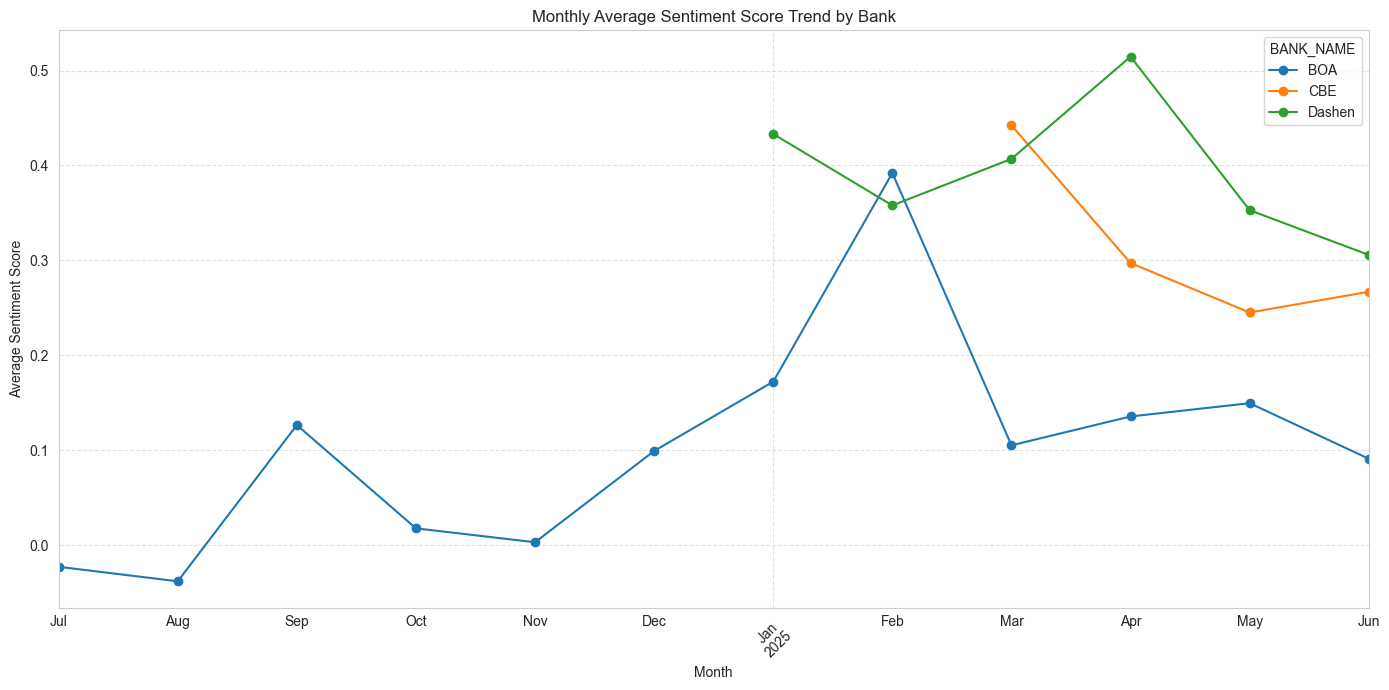

In [10]:
# Plot 4: Sentiment Trend over Time (Monthly Average Sentiment Score)
df['review_month'] = df['REVIEW_DATE'].dt.to_period('M')
monthly_sentiment = df.dropna(subset=['review_month']).groupby(['review_month', 'BANK_NAME'])['SENTIMENT_SCORE'].mean().unstack()

plt.figure(figsize=(14, 7))
if not monthly_sentiment.empty:
    monthly_sentiment.plot(kind='line', marker='o', ax=plt.gca())
    plt.title('Monthly Average Sentiment Score Trend by Bank')
    plt.xlabel('Month')
    plt.ylabel('Average Sentiment Score')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to plot monthly sentiment trend.")


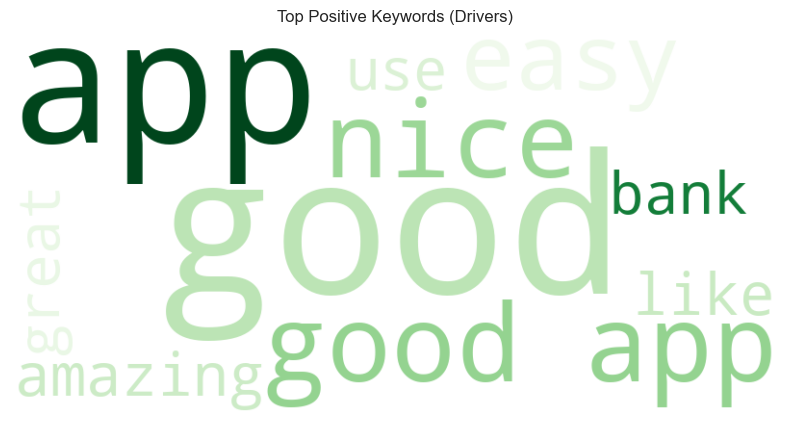

In [12]:
# Plot 5: Word Cloud for Top Positive Keywords (Drivers)
if drivers:
    positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate_from_frequencies(drivers)
    plt.figure(figsize=(10, 5))
    plt.imshow(positive_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Top Positive Keywords (Drivers)')
    plt.show()
else:
    print("Cannot generate positive word cloud: No positive keywords identified.")


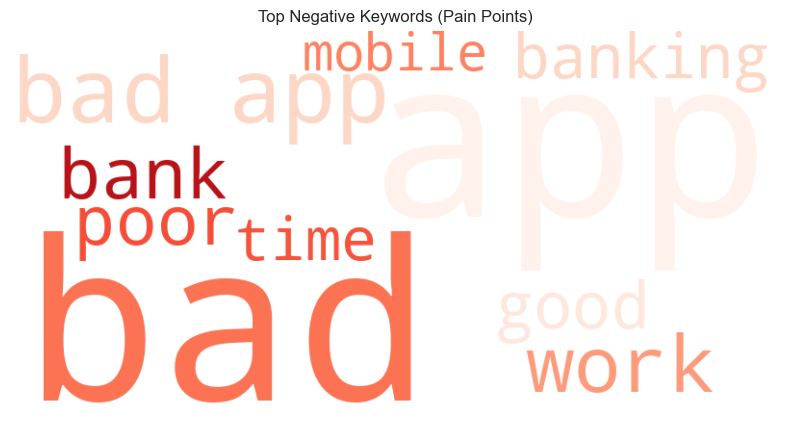

In [13]:
# Plot 6: Word Cloud for Top Negative Keywords (Pain Points)
if pain_points:
    negative_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(pain_points)
    plt.figure(figsize=(10, 5))
    plt.imshow(negative_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Top Negative Keywords (Pain Points)')
    plt.show()
else:
    print("Cannot generate negative word cloud: No negative keywords identified.")
